## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Loading the Data

In [3]:
traffic_df = pd.read_csv("../data/Metro_Interstate_Traffic_Volume.csv")
pd.DataFrame.info(traffic_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [4]:
# Here we want to change the date_time column to be the index of our dataframe
# This makes the dataframe easier to use later on

traffic_df['date_time'] = pd.to_datetime(traffic_df['date_time'])
traffic_df.set_index('date_time', inplace = True)

traffic_df['holiday'] = traffic_df['holiday'].astype(str)

## Visualizing Our Data

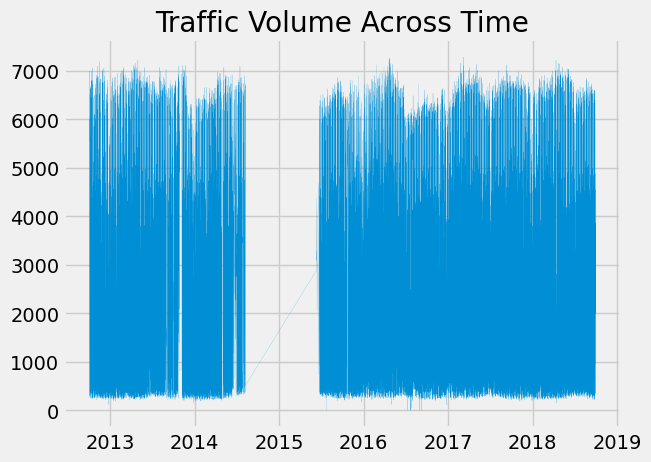

In [5]:
plt.plot(traffic_df.index,
         traffic_df['traffic_volume'],
         linewidth = 0.1)
plt.title("Traffic Volume Across Time")
plt.show()

## Time Series Split

In [5]:
# We will create a new dataframe called future_data that will be used to evaluate the model
future_data = traffic_df.loc[(traffic_df.index >= '2018-09-25')]

# The model will be trained and tested with the following dataframe
traffic_df = traffic_df.loc[(traffic_df.index < '2018-09-25')]

In [6]:
from sklearn.model_selection import TimeSeriesSplit

# Now we will create train-test splits
tss = TimeSeriesSplit(n_splits = 10, gap = 0)
traffic_df = traffic_df.sort_index()

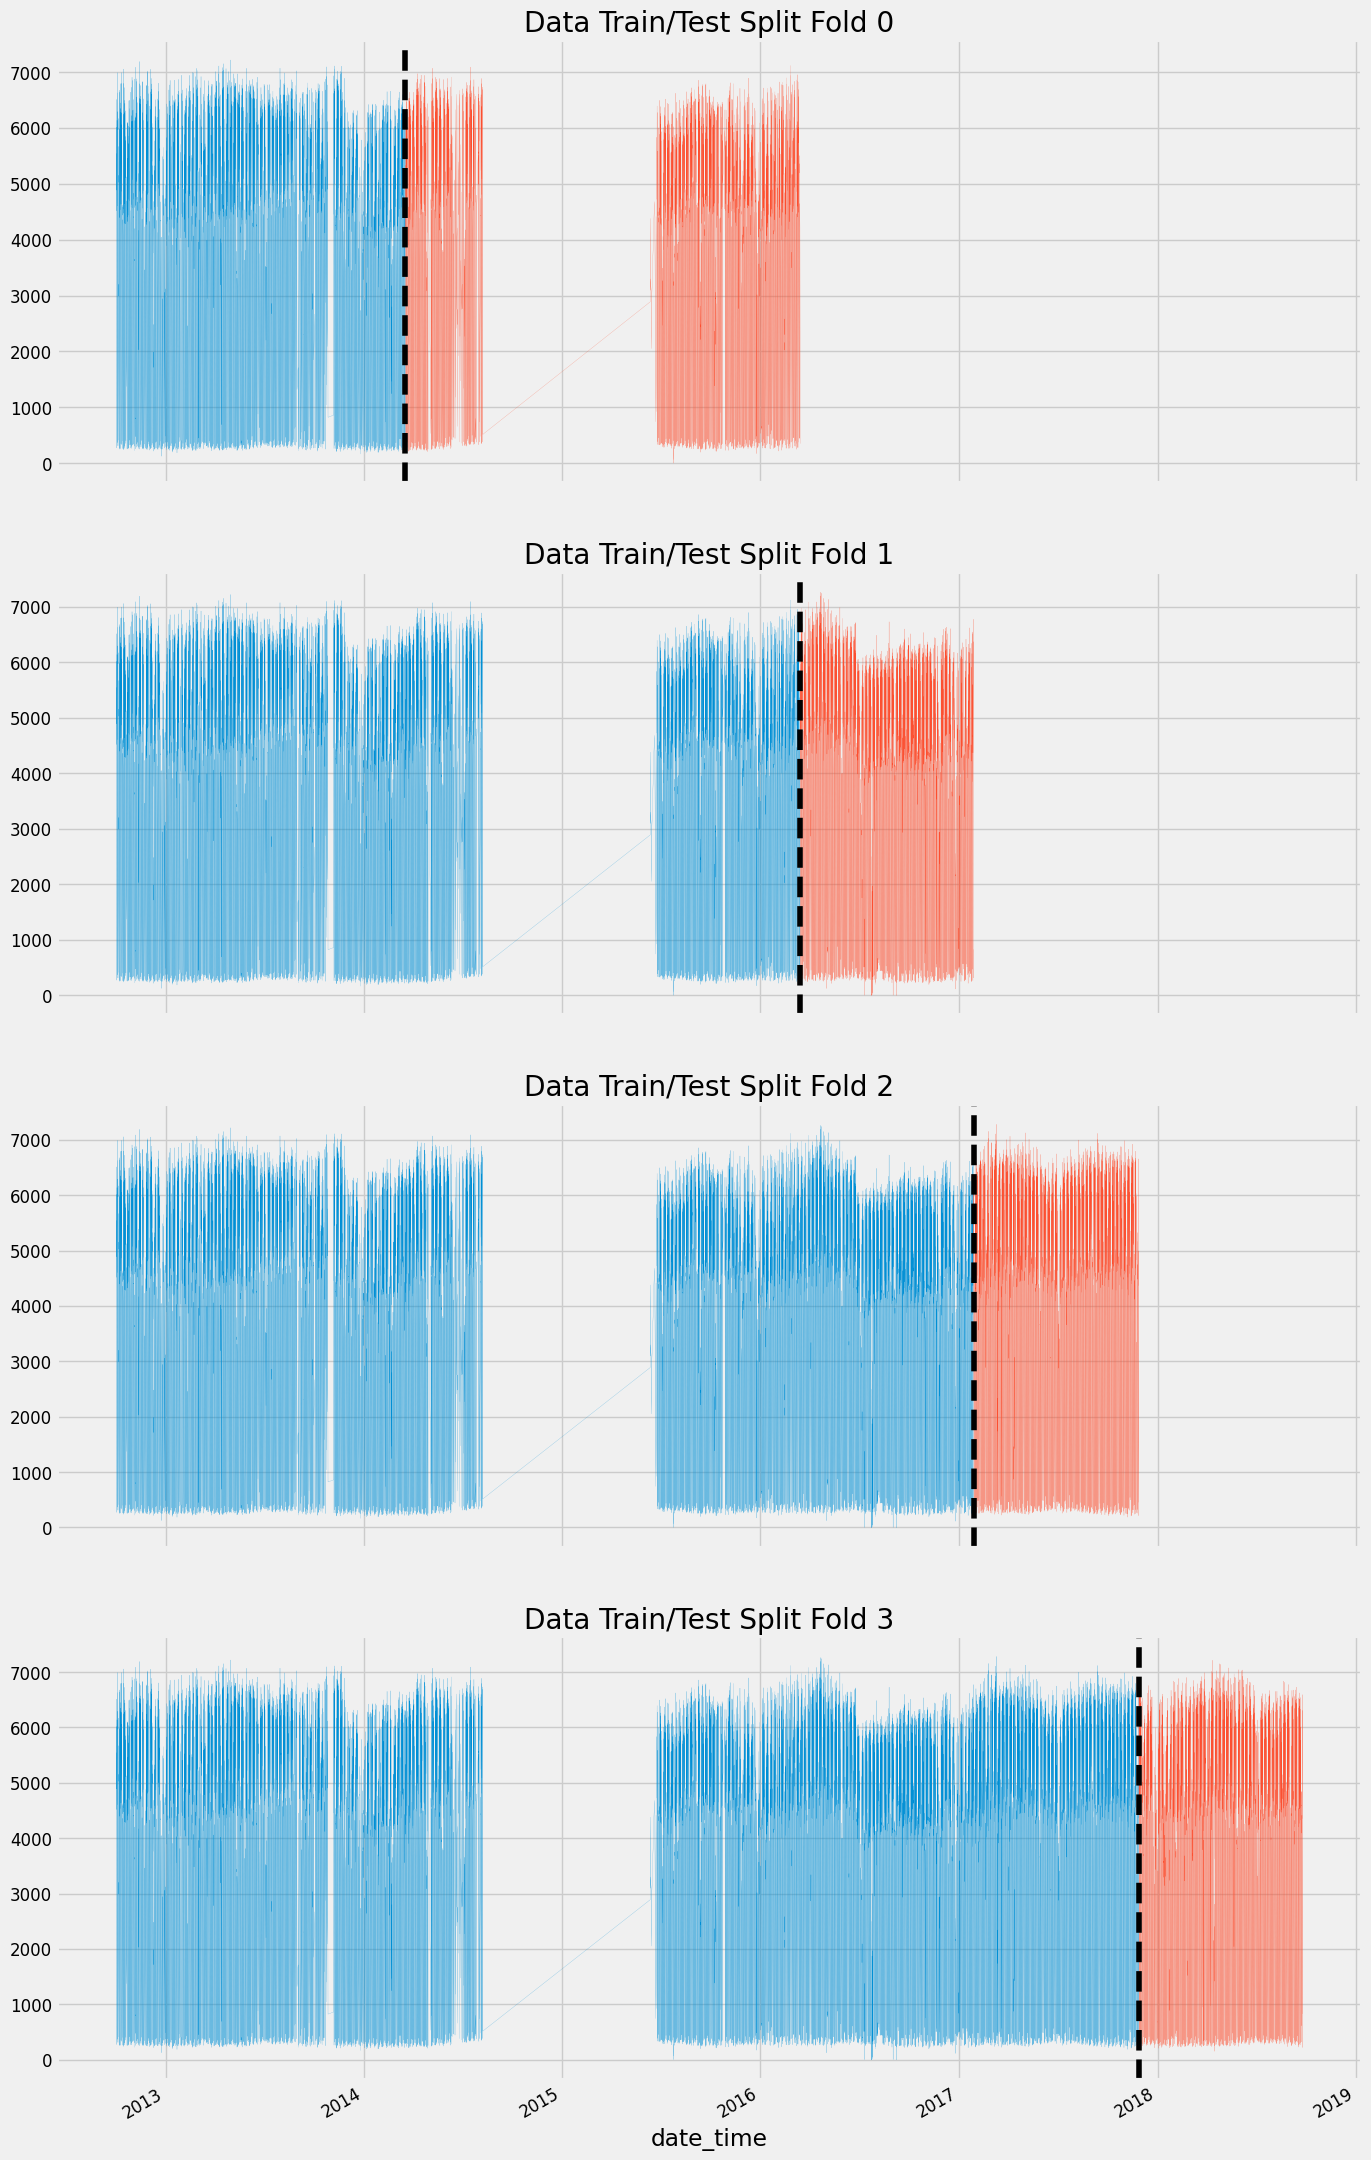

In [7]:
# Here we visualize these train-test splits
fig, axs = plt.subplots(10, 1, figsize = (15, 30), sharex = True)
fold = 0

for train_idx, val_idx in tss.split(traffic_df):
    
    train = traffic_df.iloc[train_idx]
    test = traffic_df.iloc[val_idx]
    
    train['traffic_volume'].plot(ax = axs[fold],
                                 label = 'Training Set',
                                 title = f'Data Train/Test Split Fold {fold}',
                                 fontsize = 12,
                                 linewidth = 0.1)
    
    test['traffic_volume'].plot(ax = axs[fold],
                                label = 'Test Set',
                                linewidth = 0.1)
    
    axs[fold].axvline(test.index.min(), 
                      color = 'black',
                      ls = '--')
    fold += 1
    
plt.show()

## Main Feature Creation

In [8]:
def create_features(df):
    
    df = df.copy()
    
    # Time Features
    df['DayOfYear']  = df.index.dayofyear
    df['DayOfMonth'] = df.index.day
    df['DayOfWeek']  = df.index.dayofweek
    df['Year']       = df.index.year
    df['Month']      = df.index.month
    df['Hour']       = df.index.hour
    
    # Holiday Boolean
    df['isHoliday'] = np.where(df['holiday'] != "None", True, False)
    
    return df

In [9]:
traffic_df = create_features(traffic_df)

## Quantifying our Categorical Variables

In [10]:
# See the unique values
traffic_df['weather_main'].unique()

array(['Clouds', 'Clear', 'Rain', 'Drizzle', 'Mist', 'Haze', 'Fog',
       'Thunderstorm', 'Snow', 'Squall', 'Smoke'], dtype=object)

In [11]:
traffic_df['holiday'].unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [12]:
# Extract the values from the weather_main column into a variable

unique_weathers = traffic_df['weather_main'].values

# Creatw a new column where we factorize the values of weather_main

traffic_df['weath_cat'] = pd.factorize(unique_weathers)[0]
traffic_df.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,DayOfYear,DayOfMonth,DayOfWeek,Year,Month,Hour,isHoliday,weath_cat
date_time,,,,,,,,,,,,,,,,
2018-09-24 22:00:00,None,290.01,2.29,0.0,90,Mist,mist,1392,267,24,0,2018,9,22,False,4
2018-09-24 22:00:00,None,290.01,2.29,0.0,90,Drizzle,light intensity drizzle,1392,267,24,0,2018,9,22,False,3
2018-09-24 23:00:00,None,288.62,4.74,0.0,90,Rain,heavy intensity rain,826,267,24,0,2018,9,23,False,2
2018-09-24 23:00:00,None,288.62,4.74,0.0,90,Mist,mist,826,267,24,0,2018,9,23,False,4
2018-09-24 23:00:00,None,288.62,4.74,0.0,90,Thunderstorm,thunderstorm with heavy rain,826,267,24,0,2018,9,23,False,7


In [13]:
# Repeat the process for the holiday and weather_desc columns

holidays = traffic_df['holiday'].values
traffic_df['holiday_cat'] = pd.factorize(holidays)[0]

weather_descs = traffic_df['weather_description'].values
traffic_df['weather_desc_cat'] = pd.factorize(weather_descs)[0]

# Checkthe newly created weather_desc_cat column to ensure a max of 37

traffic_df['weather_desc_cat'].describe()

count    48049.000000
mean         6.776020
std          8.030284
min          0.000000
25%          2.000000
50%          3.000000
75%          7.000000
max         37.000000
Name: weather_desc_cat, dtype: float64

In [14]:
# Call the info() function to ensure no nulls exist in our new columns
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48049 entries, 2012-10-02 09:00:00 to 2018-09-24 23:00:00
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48049 non-null  object 
 1   temp                 48049 non-null  float64
 2   rain_1h              48049 non-null  float64
 3   snow_1h              48049 non-null  float64
 4   clouds_all           48049 non-null  int64  
 5   weather_main         48049 non-null  object 
 6   weather_description  48049 non-null  object 
 7   traffic_volume       48049 non-null  int64  
 8   DayOfYear            48049 non-null  int64  
 9   DayOfMonth           48049 non-null  int64  
 10  DayOfWeek            48049 non-null  int64  
 11  Year                 48049 non-null  int64  
 12  Month                48049 non-null  int64  
 13  Hour                 48049 non-null  int64  
 14  isHoliday            48049 non-null  bool   
 15  w

In [15]:
traffic_df = traffic_df.drop(['holiday','weather_main','weather_description'], axis =1)
traffic_df.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,DayOfYear,DayOfMonth,DayOfWeek,Year,Month,Hour,isHoliday,weath_cat,holiday_cat,weather_desc_cat
date_time,,,,,,,,,,,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40,5545,276,2,1,2012,10,9,False,0,0,0
2012-10-02 10:00:00,289.36,0.0,0.0,75,4516,276,2,1,2012,10,10,False,0,0,1
2012-10-02 11:00:00,289.58,0.0,0.0,90,4767,276,2,1,2012,10,11,False,0,0,2
2012-10-02 12:00:00,290.13,0.0,0.0,90,5026,276,2,1,2012,10,12,False,0,0,2
2012-10-02 13:00:00,291.14,0.0,0.0,75,4918,276,2,1,2012,10,13,False,0,0,1


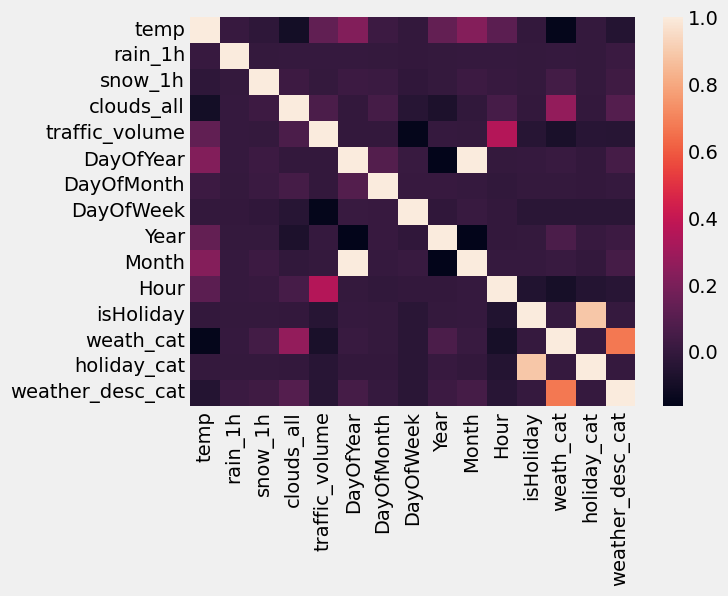

In [16]:
corr_mat = sns.heatmap(traffic_df.corr())
plt.show()

## A Bit of Exploring
We see in the plot above that `Hour` is the major variable correlated with `traffic_volume`. Another variable with weaker correlation is `temp`. Let's see how traffic volume actually changes throughout the day and month. We also check if we can identify any sort of trend throughout the years.

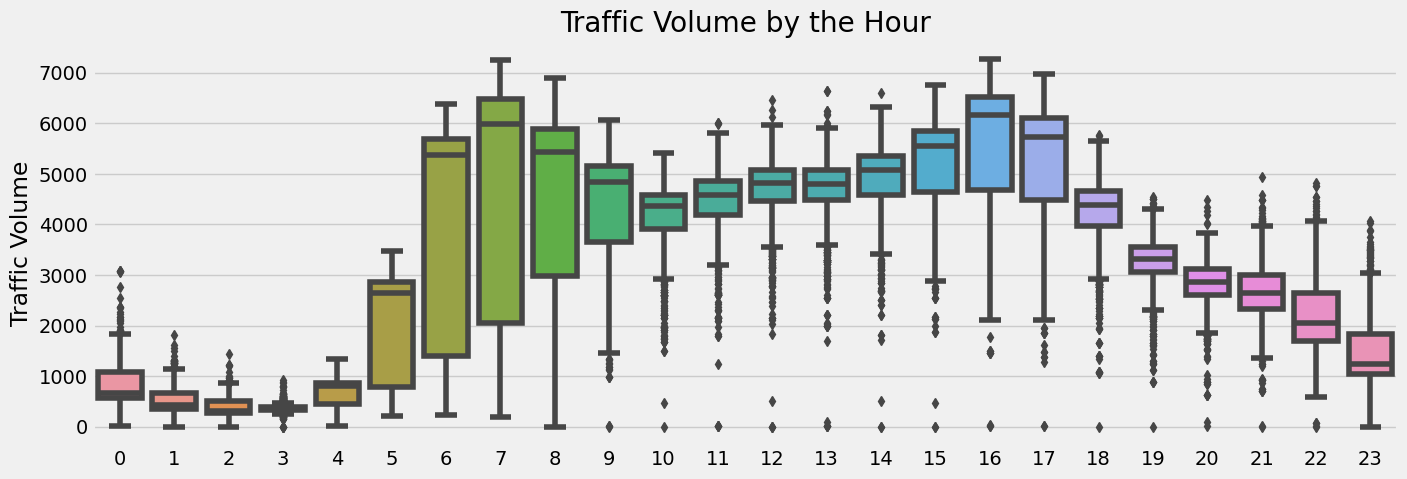

In [17]:
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = traffic_df, x = 'Hour', y = 'traffic_volume')
ax.set_title('Traffic Volume by the Hour')
plt.xlabel("")
plt.ylabel("Traffic Volume")
plt.show();

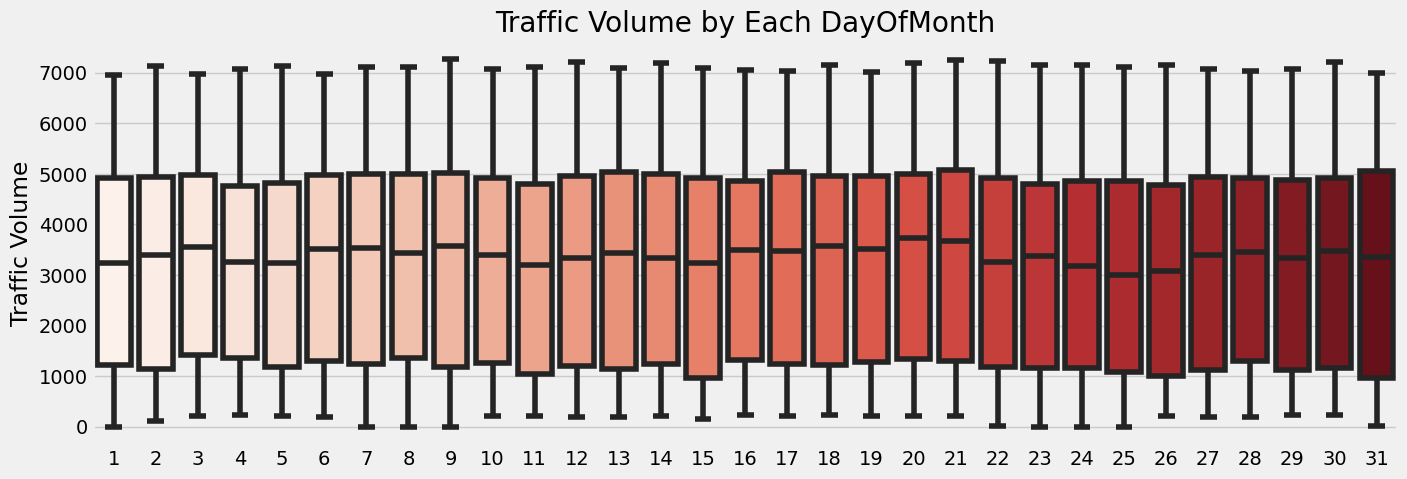

In [18]:
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = traffic_df, x = 'DayOfMonth', y = 'traffic_volume', palette = 'Reds')
ax.set_title('Traffic Volume by Each DayOfMonth')
plt.xlabel("")
plt.ylabel("Traffic Volume")
plt.show();

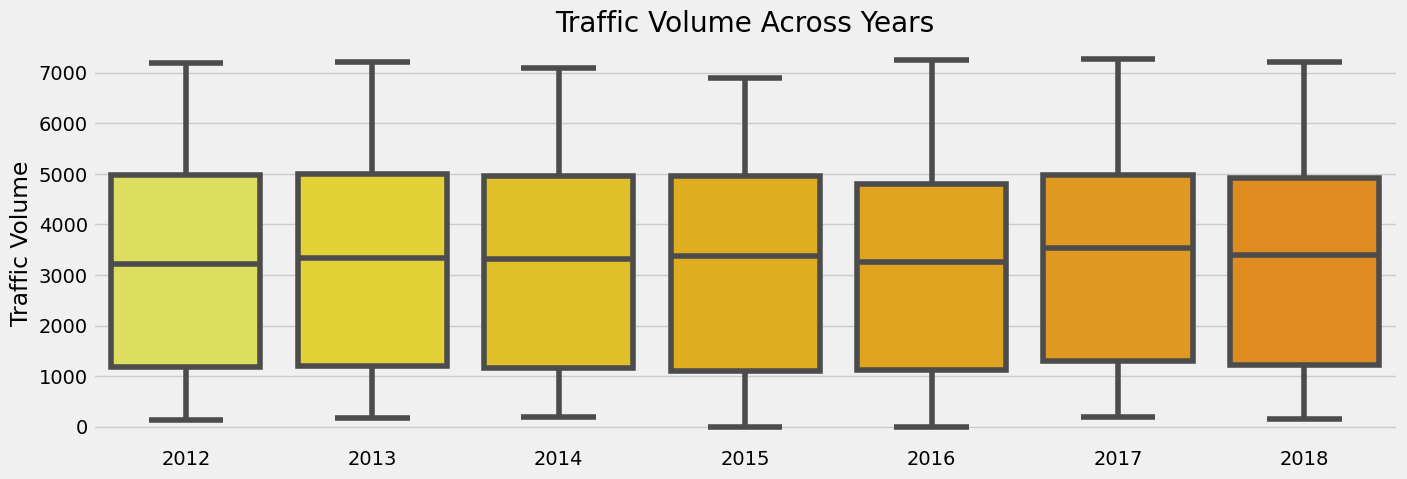

In [19]:
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = traffic_df, x = 'Year', y = 'traffic_volume', palette = 'Wistia')
ax.set_title('Traffic Volume Across Years')
plt.xlabel("")
plt.ylabel("Traffic Volume")
plt.show();

## Create Lag Variables

In [20]:
def create_lag(df):
    target_map = df['traffic_volume'].to_dict()

    # Hour Lag
    df['lag1'] = (df.index - pd.Timedelta(1, "h")).map(target_map)

    # Day Lag
    df['lag2'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('28 days')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('364 days')).map(target_map)

    # Moving Averages
    df['7D_SMA'] = df['traffic_volume'].rolling(168).mean().shift(1) # 7 * 24 = 168
    return df

In [21]:
traffic_df = create_lag(traffic_df)

## Creating the Model
Now, we can actually start training our model. We have chosen several lag variables and features. These were motivated by general intuition of how highways operate.

In [22]:
from sklearn.model_selection import GridSearchCV

initial_prediction = traffic_df['traffic_volume'].iloc[-1]

FEATURES = ['DayOfYear', 'DayOfMonth', 'DayOfWeek', 'Year', 'Month',
            'Hour', 'isHoliday', 'lag1', 'lag2', 'lag3', 'lag4', '7D_SMA']

TARGET = 'traffic_volume'

X = traffic_df[FEATURES]
y = traffic_df[TARGET]

params = {'base_score' : [initial_prediction], 
          'booster' : ['gbtree'],    
          'n_estimators' : [2000],
          'objective' : ['reg:squarederror'],
          'learning_rate': [0.01],
          'gamma' : [0.25, 0.5],
          'alpha' : [0],     # L1 (Lasso Regression) Regularization Parameter
          'lambda' : [1.25], # L2 (Ridge Regression) Regularization Parameter
          'max_depth': [3],
          'min_child_weight': [1],
          'random_state' : [42]
         }

model = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator = model, 
                           param_grid = params, 
                           scoring = 'neg_mean_absolute_percentage_error',
                           n_jobs = -1, 
                           cv = tss,  
                           refit = True).fit(X, y)

best_params = grid_search.best_params_
print(f'Model: {model} The best parameters are: {best_params}')

Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) The best parameters are: {'alpha': 0, 'base_score': 826, 'booster': 'gbtree', 'gamma': 0.25, 'lambda': 1.25, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 2000, 'objective': 'reg:squarederror', 'random_state': 42}


In [23]:
# Retrain all the data
final_model = xgb.XGBRegressor(**best_params) # Unpack dictionary
final_model.fit(X, y)

XGBRegressor(alpha=0, base_score=826, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.25, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1.25, learning_rate=0.01,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None, ...)

## Feature Importance
Here we calculate the importance of each variable to the result of the prediction.

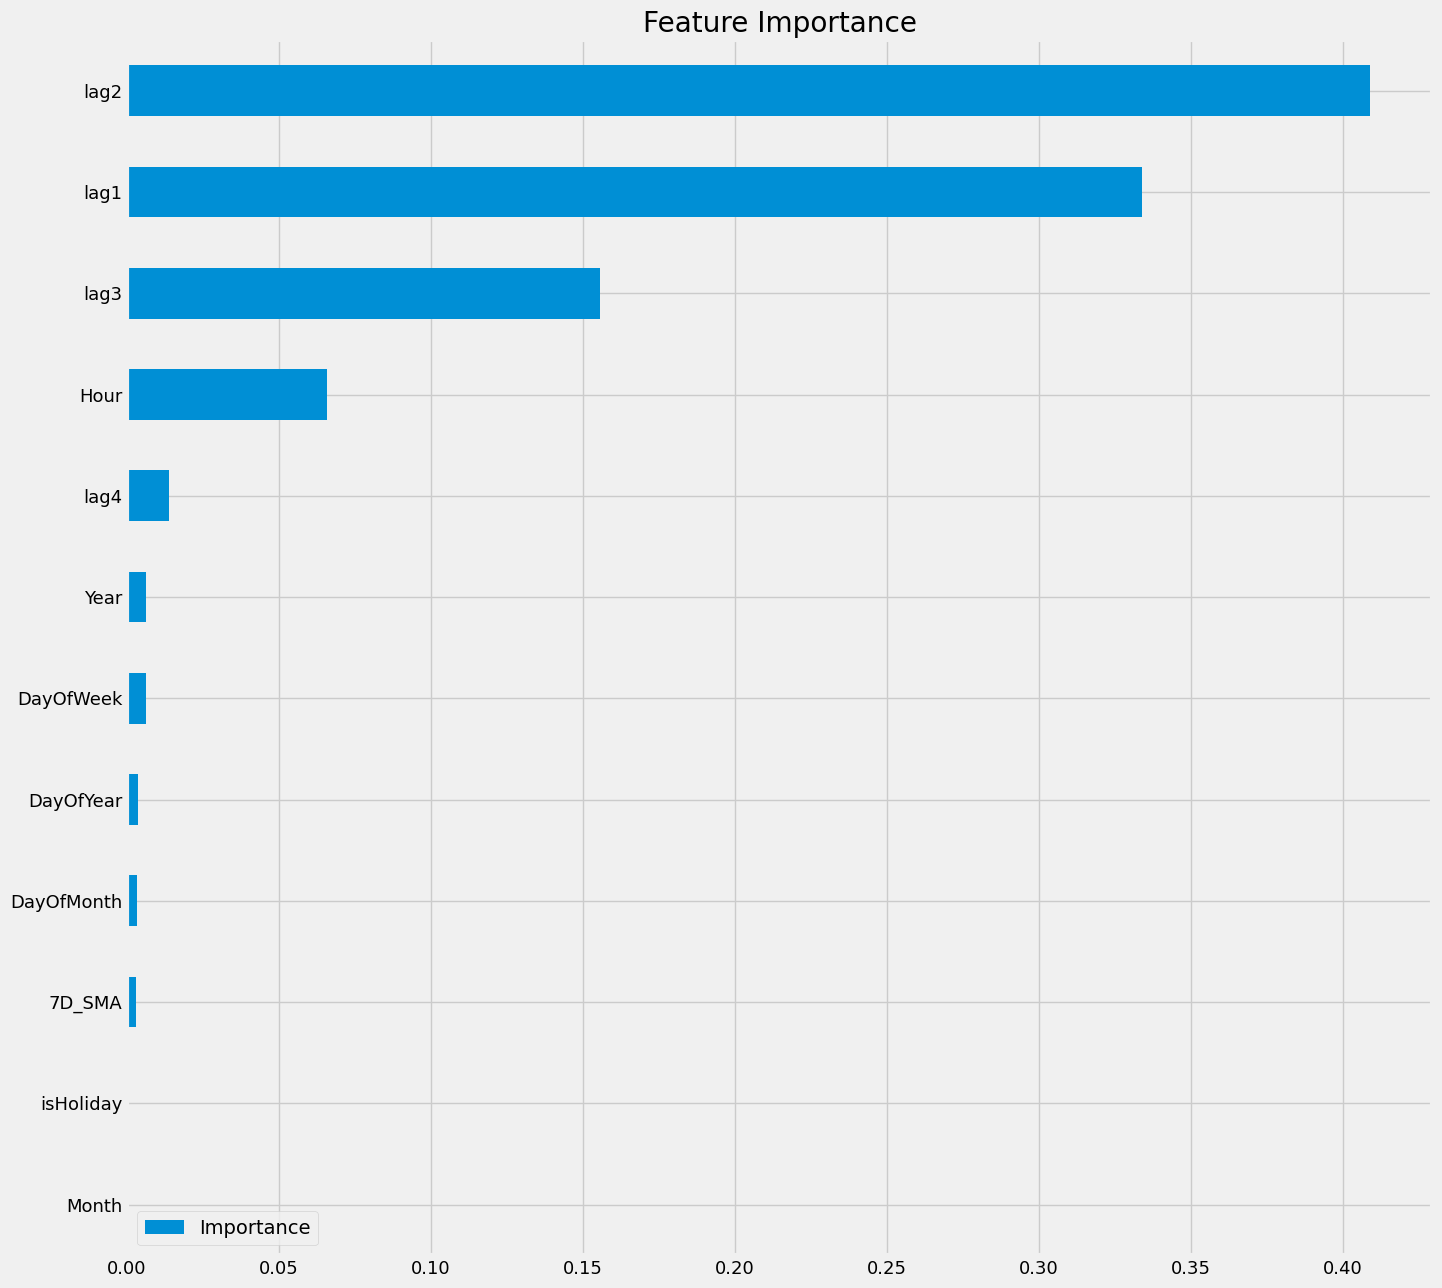

In [24]:
fi = pd.DataFrame(data = final_model.feature_importances_, index = final_model.feature_names_in_,
                  columns = ['Importance'])
fi.sort_values('Importance').plot(kind = 'barh', title = 'Feature Importance', fontsize = 13, figsize = (15,15))
plt.show()

## Traffic Volume Forecasting

In [25]:
# Download data and create future DataFrame
future_data['isFuture'] = True
traffic_df['isFuture'] = False

# Create dataframe to compare the two datasets later on
comparison_df = pd.DataFrame(future_data['traffic_volume'])

# We should also clear the data columns for the future data
# This makes sure we don't use future unknown data for our prediction
future_data['clouds_all'] = np.NaN
future_data['rain_1h'] = np.NaN
future_data['snow_1h'] = np.NaN
future_data['temp'] = np.NaN
future_data['traffic_volume'] = np.NaN
future_data['weather_description'] = np.NaN
future_data['weather_main'] = np.NaN

# We don't need to do this for 'holiday', because we already know the calendar in advance

present_and_future = pd.concat([traffic_df, future_data])
present_and_future = create_features(present_and_future)
present_and_future = create_lag(present_and_future)

In [26]:
# Predicting the future and compare with actual data
future_w_features = present_and_future.query('isFuture').copy()

# Run the model
future_w_features['Prediction'] = final_model.predict(future_w_features[FEATURES])

# Merge the prediction and comparison datasets to evaluate our results
final_df = comparison_df.merge(future_w_features['Prediction'], how = 'left', left_index = True, right_index = True)

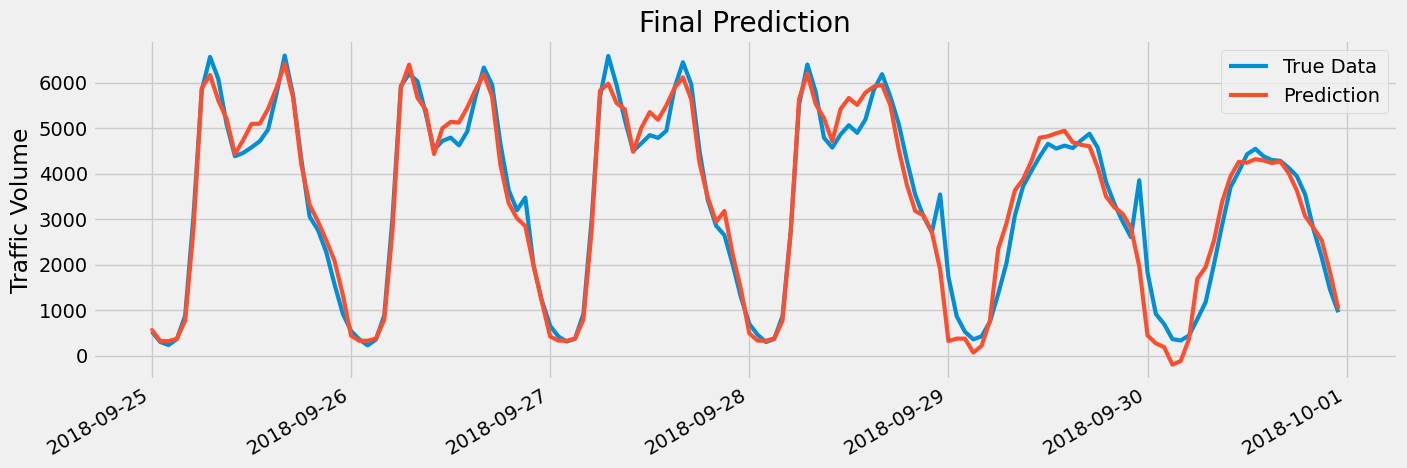

In [27]:
# Plot the data
ax = final_df[['traffic_volume']].plot(figsize = (15,5), linewidth = 3)
final_df['Prediction'].plot(ax = ax, linewidth = 3)
plt.legend(['True Data', 'Prediction'])
plt.xlabel("")
plt.ylabel("Traffic Volume")
ax.set_title('Final Prediction')
plt.show()

## Calculating Mean Error

In [28]:
mape_score = mean_absolute_percentage_error(final_df['traffic_volume'], final_df['Prediction']) * 100
rmse_score = np.sqrt(mean_squared_error(final_df['traffic_volume'], final_df['Prediction']))
print(f'MAPE on Target Data: {mape_score:0.2f}%')
print(f'RMSE on Target Data: {rmse_score:0.2f}')

MAPE on Target Data: 14.74%
RMSE on Target Data: 412.22
